In [80]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [81]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [82]:
len(words)

32033

In [83]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [84]:
# build the dataset

block_size = 3 # context length: how many characters do we take to predict the next one?
X, Y = [], []
for w in words:
  #print(w)
  context = [0] * block_size
  for ch in w + '.':
    ix = stoi[ch]
    X.append(context)
    Y.append(ix)
    #print(''.join(itos[i] for i in context), '--->', itos[ix])
    context = context[1:] + [ix] # crop and append
  
X = torch.tensor(X)
Y = torch.tensor(Y)

In [85]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([228146, 3]), torch.int64, torch.Size([228146]), torch.int64)

In [86]:
X, Y

(tensor([[ 0,  0,  0],
         [ 0,  0,  5],
         [ 0,  5, 13],
         ...,
         [26, 26, 25],
         [26, 25, 26],
         [25, 26, 24]]),
 tensor([ 5, 13, 13,  ..., 26, 24,  0]))

In [87]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [88]:
C = torch.randn((27, 2))

In [89]:
emb = C[X]
emb.shape

torch.Size([228146, 3, 2])

In [90]:
W1 = torch.randn((6, 100))
b1 = torch.randn(100)

In [91]:
emb.view(-1, 6), emb.view(-1, 6).shape

(tensor([[-0.6530, -1.0755, -0.6530, -1.0755, -0.6530, -1.0755],
         [-0.6530, -1.0755, -0.6530, -1.0755, -0.5174,  0.2718],
         [-0.6530, -1.0755, -0.5174,  0.2718, -0.4469, -1.1374],
         ...,
         [ 0.2755,  0.3477,  0.2755,  0.3477,  0.0704, -0.2183],
         [ 0.2755,  0.3477,  0.0704, -0.2183,  0.2755,  0.3477],
         [ 0.0704, -0.2183,  0.2755,  0.3477, -1.7009,  0.4410]]),
 torch.Size([228146, 6]))

In [92]:
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)

In [93]:
h

tensor([[ 0.8271, -0.1293,  0.0449,  ..., -0.8760, -0.6287, -0.9987],
        [-0.8769,  0.0352, -0.3392,  ..., -0.5588, -0.8707, -0.9914],
        [ 0.9557, -0.1053, -0.0157,  ..., -0.9810,  0.8404, -0.9714],
        ...,
        [ 0.1678,  0.4768, -0.2727,  ..., -0.8673,  0.4916, -0.1047],
        [-0.8463,  0.6980, -0.5695,  ..., -0.5216, -0.4357,  0.1531],
        [-0.3918, -0.9581,  0.1565,  ..., -0.4742, -0.7237, -0.9983]])

In [94]:
h.shape

torch.Size([228146, 100])

In [95]:
W2 = torch.randn((100, 27))
b2 = torch.randn(27)

In [96]:
logits = h @ W2 + b2

In [97]:
logits.shape

torch.Size([228146, 27])

In [98]:
counts = logits.exp()

In [99]:
import torch.nn.functional as F
torch_prob = F.softmax(logits, dim=1)

prob = counts / counts.sum(1, keepdims=True)

In [100]:
torch_prob.shape, prob.shape

(torch.Size([228146, 27]), torch.Size([228146, 27]))

In [101]:
torch_prob, prob

(tensor([[1.2451e-04, 1.6143e-10, 3.1845e-08,  ..., 8.7071e-07, 1.5159e-02,
          8.0214e-04],
         [8.7576e-05, 4.1391e-11, 7.2148e-07,  ..., 1.0232e-05, 6.4191e-01,
          1.6039e-02],
         [1.1953e-02, 5.2677e-08, 7.9195e-11,  ..., 1.2744e-06, 6.8289e-06,
          4.2927e-06],
         ...,
         [2.0596e-03, 6.2554e-07, 1.8410e-08,  ..., 1.9661e-12, 6.6623e-08,
          1.6648e-07],
         [8.3807e-08, 2.2585e-08, 1.3418e-08,  ..., 9.8076e-12, 5.1352e-07,
          3.1258e-08],
         [2.5559e-03, 2.9401e-08, 1.8545e-05,  ..., 4.2977e-11, 3.1059e-06,
          2.3963e-05]]),
 tensor([[1.2451e-04, 1.6143e-10, 3.1844e-08,  ..., 8.7071e-07, 1.5159e-02,
          8.0214e-04],
         [8.7576e-05, 4.1391e-11, 7.2148e-07,  ..., 1.0232e-05, 6.4191e-01,
          1.6039e-02],
         [1.1953e-02, 5.2677e-08, 7.9195e-11,  ..., 1.2744e-06, 6.8289e-06,
          4.2927e-06],
         ...,
         [2.0596e-03, 6.2554e-07, 1.8410e-08,  ..., 1.9661e-12, 6.6623e-08,
   

In [102]:
# loss = -prob[torch.arange(32), Y].log().mean()
# loss

In [103]:
# ------------ now made respectable :) ---------------

In [104]:
Xtr.shape, Ytr.shape # dataset

(torch.Size([182625, 3]), torch.Size([182625]))

In [105]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 10), generator=g)
W1 = torch.randn((30, 200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [106]:
sum(p.nelement() for p in parameters) # number of parameters in total

11897

In [107]:
for p in parameters:
  p.requires_grad = True

In [108]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [109]:
lri = []
lossi = []
stepi = []

In [110]:
for i in range(200_000):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (32,))
  
  # forward pass
  emb = C[Xtr[ix]] # (32, 3, 10)
  h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 200)
  logits = h @ W2 + b2 # (32, 27)
  loss = F.cross_entropy(logits, Ytr[ix])
  #print(loss.item())
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  #lr = lrs[i]
  lr = 0.1 if i < 100000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  #lri.append(lre[i])
  stepi.append(i)
  lossi.append(loss.log10().item())

print(loss.item())

1.5801701545715332


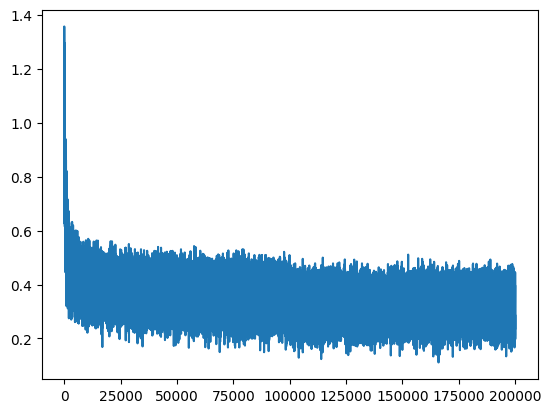

In [111]:
plt.plot(stepi, lossi)

In [112]:
emb = C[Xtr] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.1291, grad_fn=<NllLossBackward0>)

In [113]:
emb = C[Xdev] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.1687, grad_fn=<NllLossBackward0>)

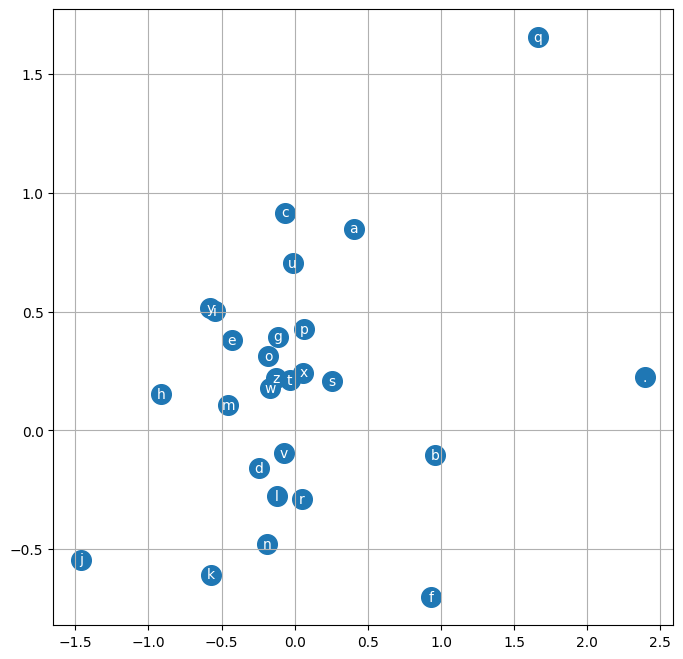

In [114]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

In [115]:
# training split, dev/validation split, test split
# 80%, 10%, 10%

In [116]:
context = [0] * block_size
C[torch.tensor([context])].shape

torch.Size([1, 3, 10])

In [117]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))

carmah.
amelle.
khy.
mili.
taty.
skaan.
kenleine.
faresynci.
geni.
ner.
kia.
chaiivia.
legg.
halm.
join.
quinn.
shoine.
liveni.
waje.
maijaryni.
